# Spark MLlib: Aprendizaje No Supervisado

## Omar Gaston - oy-gastonc@javeriana.edu.co

Este cuaderno muestra cómo:

1. Cargar y explorar un conjunto de datos
2. Preparar datos para el aprendizaje automático
3. Entrenar dos modelos de aprendizaje no supervisado diferentes
4. Evaluar y comparar el rendimiento de los modelos

**Modelos**: K-Means vs. Bisecting K-Means

**Conjunto de datos**: Calidad de vinos

## Contexto del Problema


### Descubrimiento de grupos en Vinos

A diferencia del aprendizaje supervisado donde teníamos etiquetas de calidad, ahora encontramos con un desafío diferente: queremos saber si existen grupos naturales de vinos basados en sus propiedades químicas.

### ¿Por qué Aprendizaje No Supervisado?

Usamos el aprendizaje no supervisado para lograr encontrar patrones y relaciones en un dataset.

### Pregunta de Investigación

¿Las propiedades químicas del vino generan clusters que se correlacionan con la calidad percibida?

### Algoritmos a Comparar

| Algoritmo | Enfoque | 
|-----------|---------|
| **K-Means** | Partición iterativa |
| **Bisecting K-Means** | División jerárquica |

---

Instalamos los paquetes necesarios, agregando `%%capture` para no mostrar el output en el notebook. Luego ignoramos los `warning` emitidos por python y finalmente inicializamos spark.

In [32]:
%%capture
!pip install findspark
!pip install pandas numpy matplotlib seaborn

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Bibliotecas de PySpark MLlib y la inicializacion para la sesion.

import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

---

## 1. Iniciar la sesión de Spark Session

Para este cuaderno utilizaremos una configuracion de spark que nos permita utilizar al menos **4 cores** y **4g de memoria** ya que esta configuracion fue la mas optima para este experimento.

In [4]:
# Importar librerias necesarias
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import pandas as pd

sparkConf = (
    SparkConf()
        .set("spark.scheduler.mode", "FAIR")
        .set("spark.shuffle.io.maxRetries", "10")
        .set("spark.shuffle.io.retryWait", "60s") 
        .set("spark.network.timeout", "600s") 
        .set("spark.executor.heartbeatInterval", "60s")
)

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Omar MLib No Supervisado") \
    .config(conf=sparkConf) \
    .getOrCreate()

# Ocultar warnings
spark.sparkContext.setLogLevel("ERROR")

SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)

print(f"Spark Version: {spark.version}")
print("Spark Session creada exitosamente!")

Spark Version: 3.5.0
Spark Session creada exitosamente!


## 2. Cargar y explorar el Dataset

### Análisis de Clusters encontrados

Nos preguntamos: ¿Los clusters descubiertos coinciden con la calidad del vino?

Lo que esperamos encontrar es que los cluster esten relacionados con la calidad de cada grupo de vino:
- Cluster 0 ≈ vinos de baja calidad
- Cluster 1 ≈ vinos de calidad media
- Cluster 2 ≈ vinos de alta calidad

**Si NO hay patrón diagonal:**
- Los clusters estan capturando otra dimensión (ej: estilo de vino, región)
- La calidad percibida no está relacionada con los componentes químicos
- K=3 puedria no ser el número óptimo de clusters


In [6]:
import urllib.request

# Descargar
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
local_path = "winequality-red.csv"

print("Descargando dataset...")
urllib.request.urlretrieve(url, local_path)
print("Descarga completa!")

# Leer CSV
df = spark.read.csv(
    local_path,
    header=True,
    inferSchema=True,
    sep=";"
)

# Guardar la columna quality para análisis posterior
df = df.withColumnRenamed("quality", "true_quality")

print("\nDataset cargado exitosamente!")
print(f"Total: {df.count()}")
print(f"\nSchema:")
df.printSchema()

Descargando dataset...
Descarga completa!

Dataset cargado exitosamente!
Total: 1599

Schema:
root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- true_quality: integer (nullable = true)



In [7]:
# Mostrar primeras filas
print("Primeras 5 filas del dataset:")
df.show(5)

Primeras 5 filas del dataset:
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|true_quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|           5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|           5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|           5|
|         11.2|            0.28|       0

In [8]:
# Verificar la distribución de calidad del vino (para análisis posterior)
print("Distribución de Calidad del Vino (referencia):")
df.groupBy('true_quality').count().orderBy('true_quality').show()

Distribución de Calidad del Vino (referencia):
+------------+-----+
|true_quality|count|
+------------+-----+
|           3|   10|
|           4|   53|
|           5|  681|
|           6|  638|
|           7|  199|
|           8|   18|
+------------+-----+



In [9]:
# Resumen estadístico
print("Resumen Estadístico:")
df.describe().show()

Resumen Estadístico:
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|      true_quality|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|              1599|       

## 3. Preparacion de Features

### Normalización

Ya que K-Means usa **distancia euclidiana** para asignar puntos a clusters, Sin normalización, una variable con rango 0-100 dominaría sobre una variable con rango 0-1.

**Ejemplo concreto del dataset:**

| Variable | Rango |
|----------|----------------|
| `total sulfur dioxide` | 6-289 | 
| `chlorides` | 0.012-0.611 | 

Aca vemos que el dióxido de azufre tendría 222,000 veces más peso que los cloruros.

**Después de StandardScaler:**

Ambas variables tienen media=0 y desviación estándar=1, contribuyendo equitativamente.


In [10]:
# Definir columnas de características (todas excepto 'true_quality')
feature_cols = [col for col in df.columns if col != 'true_quality']

print(f"Features: {feature_cols}")
print(f"Número de features: {len(feature_cols)}")

Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Número de features: 11


In [11]:
# Ensamblar características en un vector único
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features_raw'
)

df_assembled = assembler.transform(df)

print("Vector de características creado:")
df_assembled.select('features_raw', 'true_quality').show(5, truncate=False)

Vector de características creado:
+--------------------------------------------------------+------------+
|features_raw                                            |true_quality|
+--------------------------------------------------------+------------+
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |5           |
|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8]  |5           |
|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8] |5           |
|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8]|6           |
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |5           |
+--------------------------------------------------------+------------+
only showing top 5 rows



In [12]:
# Normalizar características (importante para clustering)
scaler = StandardScaler(
    inputCol='features_raw',
    outputCol='features',
    withStd=True,
    withMean=True
)

scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

print("Características normalizadas:")
df_scaled.select('features', 'true_quality').show(5, truncate=False)

Características normalizadas:
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                                                                     |true_quality|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|[-0.528194370248706,0.9615758497615392,-1.3910371025826445,-0.45307666524694107,-0.24363046870568492,-0.4660467180570466,-0.37901411729367135,0.5580998653529516,1.288239900932479,-0.5790253785668811,-0.959945795360617]   |5           |
|[-0.2984540647668453,

## 4. Modelo 1: K-Means

### K-Means

**Funcionamiento paso a paso:**

1. Se inicializa seleccionando K centroides de forma aleatorea.
2. Se asigna cada punto al centroide mas cercano.
3. Al recalcular los puntos se va actualizando el centroide.
4. Se repite hasta la convergencia

**Hiperparámetros:**
- `k=3`: Número de clusters (ya que esperamos 3 grupos)
- `maxIter=100`: Máximo de iteraciones que permitimos
- `seed=42`: Semilla para mantener la reproducibilidad


In [13]:
# Inicializar modelo K-Means
# Usamos 3 clusters basándonos en la distribución de calidad del vino
kmeans = KMeans(
    featuresCol='features',
    predictionCol='cluster',
    k=3,
    seed=42,
    maxIter=100
)

print("Modelo K-Means inicializado")
print(f"Número de clusters: {kmeans.getK()}")
print(f"Máximo de iteraciones: {kmeans.getMaxIter()}")

Modelo K-Means inicializado
Número de clusters: 3
Máximo de iteraciones: 100


In [14]:
# Entrenar el modelo
print("Entrenando modelo K-Means...")
kmeans_model = kmeans.fit(df_scaled)
print("Entrenamiento completado!")

# Mostrar centros de clusters
print("\nCentros de los clusters:")
centers = kmeans_model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

Entrenando modelo K-Means...
Entrenamiento completado!

Centros de los clusters:
Cluster 0: [-0.64949027  0.45482336 -0.75914181 -0.2278095  -0.18857589 -0.22169673
 -0.3492025  -0.45055057  0.61394368 -0.28731165  0.06851232]
Cluster 1: [-0.08326398  0.03689358  0.1121711   0.41344509 -0.00702304  1.07746103
  1.32359867  0.28948816 -0.18373715 -0.18148029 -0.50255905]
Cluster 2: [ 1.0029099  -0.68625442  1.01510901  0.01978434  0.27832517 -0.48707891
 -0.48705379  0.43528111 -0.75118759  0.55213748  0.27771345]


In [15]:
# Hacer predicciones
kmeans_predictions = kmeans_model.transform(df_scaled)

print("Muestra de predicciones K-Means:")
kmeans_predictions.select('features', 'cluster', 'true_quality').show(10, truncate=False)

Muestra de predicciones K-Means:
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|features                                                                                                                                                                                                                      |cluster|true_quality|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|[-0.528194370248706,0.9615758497615392,-1.3910371025826445,-0.45307666524694107,-0.24363046870568492,-0.4660467180570466,-0.37901411729367135,0.5580998653529516,1.288239900932479,-0.5790253785668811,-0.959945795360617]    |0    

In [16]:
# Distribución de datos por cluster
print("Distribución de datos por cluster:")
kmeans_predictions.groupBy('cluster').count().orderBy('cluster').show()

Distribución de datos por cluster:
+-------+-----+
|cluster|count|
+-------+-----+
|      0|  724|
|      1|  375|
|      2|  500|
+-------+-----+



## 5. Modelo 2: Bisecting K-Means

### Bisecting K-Means

Esta es una variacion del KMeans donde se utliza una división por partes.

**Diferencia conceptual:**

- Kmeans coloca los 3 clusters desde el incio
- Bisecting Kmeans crea un cluster principal y luego lo va dividiendo.

**¿Por qué podría ser mejor?**

Este es menos sensible a inicialización y crea cluster mas equilibrados


In [17]:
# Inicializar modelo Bisecting K-Means
bisecting_kmeans = BisectingKMeans(
    featuresCol='features',
    predictionCol='cluster',
    k=3,
    seed=42,
    maxIter=100
)

print("Modelo Bisecting K-Means inicializado")
print(f"Número de clusters: {bisecting_kmeans.getK()}")
print(f"Máximo de iteraciones: {bisecting_kmeans.getMaxIter()}")

Modelo Bisecting K-Means inicializado
Número de clusters: 3
Máximo de iteraciones: 100


In [19]:
# Entrenar el modelo
print("Entrenando modelo Bisecting K-Means...")
bisecting_model = bisecting_kmeans.fit(df_scaled)
print("Entrenamiento completado!")

# Mostrar centros de clusters
print("\nCentros de los clusters:")
centers = bisecting_model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

Entrenando modelo Bisecting K-Means...
Entrenamiento completado!

Centros de los clusters:
Cluster 0: [ 0.92072712 -0.63617738  0.98513668  0.16097077  0.26417462 -0.23563244
 -0.21521772  0.49946635 -0.70774169  0.53147337  0.17305398]
Cluster 1: [-0.65413     0.4900334  -0.77949837 -0.2282078  -0.1853797  -0.32403413
 -0.43414218 -0.48853615  0.59396567 -0.32491552  0.10773524]
Cluster 2: [-0.32514924  0.15454312 -0.2012358   0.15288773 -0.09753438  0.98856749
  1.15748576  0.06990842  0.08201141 -0.284717   -0.48608647]


In [20]:
# Hacer predicciones
bisecting_predictions = bisecting_model.transform(df_scaled)

print("Muestra de predicciones Bisecting K-Means:")
bisecting_predictions.select('features', 'cluster', 'true_quality').show(10, truncate=False)

Muestra de predicciones Bisecting K-Means:
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|features                                                                                                                                                                                                                      |cluster|true_quality|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|[-0.528194370248706,0.9615758497615392,-1.3910371025826445,-0.45307666524694107,-0.24363046870568492,-0.4660467180570466,-0.37901411729367135,0.5580998653529516,1.288239900932479,-0.5790253785668811,-0.959945795360617]

In [21]:
# Distribución de datos por cluster
print("Distribución de datos por cluster:")
bisecting_predictions.groupBy('cluster').count().orderBy('cluster').show()

Distribución de datos por cluster:
+-------+-----+
|cluster|count|
+-------+-----+
|      0|  590|
|      1|  654|
|      2|  355|
+-------+-----+



## 6. Evaluación y Comparación de Modelos

### Evaluando Clustering


Esta evaluacion calcula que tan fuerte o definidas son las estructuras creadas de los cluster. 

> Mientras mas cercano a 1 es mas fuerte su estructura.

In [22]:
# Inicializar evaluador de clustering
evaluator = ClusteringEvaluator(
    featuresCol='features',
    predictionCol='cluster',
    metricName='silhouette'
)

print("Evaluador de clustering inicializado")
print("Métrica: Silhouette Score (valores más cercanos a 1 son mejores)")

Evaluador de clustering inicializado
Métrica: Silhouette Score (valores más cercanos a 1 son mejores)


In [23]:
# Evaluar K-Means
kmeans_silhouette = evaluator.evaluate(kmeans_predictions)

print("=" * 50)
print("RENDIMIENTO DE K-MEANS")
print("=" * 50)
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Suma de errores al cuadrado: {kmeans_model.summary.trainingCost:.4f}")

RENDIMIENTO DE K-MEANS
Silhouette Score: 0.2990
Suma de errores al cuadrado: 12622.3153


In [24]:
# Evaluar Bisecting K-Means
bisecting_silhouette = evaluator.evaluate(bisecting_predictions)

print("=" * 50)
print("RENDIMIENTO DE BISECTING K-MEANS")
print("=" * 50)
print(f"Silhouette Score: {bisecting_silhouette:.4f}")
print(f"Suma de errores al cuadrado: {bisecting_model.summary.trainingCost:.4f}")

RENDIMIENTO DE BISECTING K-MEANS
Silhouette Score: 0.2201
Suma de errores al cuadrado: 12965.2942


In [25]:
# Resumen de Comparación
comparison_df = pd.DataFrame({
    'Métrica': ['Silhouette Score', 'Error Cuadrático'],
    'K-Means': [kmeans_silhouette, kmeans_model.summary.trainingCost],
    'Bisecting K-Means': [bisecting_silhouette, bisecting_model.summary.trainingCost]
})

comparison_df['Diferencia (BKM - KM)'] = comparison_df['Bisecting K-Means'] - comparison_df['K-Means']

print("\n" + "=" * 70)
print("RESUMEN DE COMPARACIÓN DE MODELOS")
print("=" * 70)
print(comparison_df.to_string(index=False))

# Determinar el ganador
if bisecting_silhouette > kmeans_silhouette:
    print(f"\nGanador: Bisecting K-Means (Silhouette: {bisecting_silhouette:.4f})")
elif kmeans_silhouette > bisecting_silhouette:
    print(f"\nGanador: K-Means (Silhouette: {kmeans_silhouette:.4f})")
else:
    print(f"\nEmpate: Ambos modelos lograron {kmeans_silhouette:.4f} de Silhouette Score")


RESUMEN DE COMPARACIÓN DE MODELOS
         Métrica      K-Means  Bisecting K-Means  Diferencia (BKM - KM)
Silhouette Score     0.298956           0.220087              -0.078869
Error Cuadrático 12622.315300       12965.294192             342.978892

Ganador: K-Means (Silhouette: 0.2990)



**En nuestro caso:**
- K-Means: ~0.30 → Estructura débil pero presente
- Bisecting: ~0.22 → Estructura más débil

**¿Por qué son bajos estos valores?**

Los vinos de calidad intermedia (5-6) tienen propiedades químicas que se solapan con los extremos. No hay fronteras claras entre "vino malo" y "vino bueno" a nivel químico.


In [26]:
# Analizar relación entre clusters de K-Means y calidad real
print("K-Means: Distribución de calidad por cluster")
kmeans_quality_analysis = kmeans_predictions.groupBy('cluster', 'true_quality').count().orderBy('cluster', 'true_quality')
kmeans_quality_analysis.show(20)

# Calidad promedio por cluster
print("\nCalidad promedio por cluster (K-Means):")
kmeans_predictions.groupBy('cluster').avg('true_quality').orderBy('cluster').show()

K-Means: Distribución de calidad por cluster
+-------+------------+-----+
|cluster|true_quality|count|
+-------+------------+-----+
|      0|           3|    7|
|      0|           4|   38|
|      0|           5|  303|
|      0|           6|  306|
|      0|           7|   63|
|      0|           8|    7|
|      1|           4|    6|
|      1|           5|  243|
|      1|           6|  109|
|      1|           7|   16|
|      1|           8|    1|
|      2|           3|    3|
|      2|           4|    9|
|      2|           5|  135|
|      2|           6|  223|
|      2|           7|  120|
|      2|           8|   10|
+-------+------------+-----+


Calidad promedio por cluster (K-Means):
+-------+-----------------+
|cluster|avg(true_quality)|
+-------+-----------------+
|      0|5.553867403314917|
|      1|            5.368|
|      2|            5.956|
+-------+-----------------+



In [27]:
# Analizar relación entre clusters de Bisecting K-Means y calidad real
print("Bisecting K-Means: Distribución de calidad por cluster")
bisecting_quality_analysis = bisecting_predictions.groupBy('cluster', 'true_quality').count().orderBy('cluster', 'true_quality')
bisecting_quality_analysis.show(20)

# Calidad promedio por cluster
print("\nCalidad promedio por cluster (Bisecting K-Means):")
bisecting_predictions.groupBy('cluster').avg('true_quality').orderBy('cluster').show()

Bisecting K-Means: Distribución de calidad por cluster
+-------+------------+-----+
|cluster|true_quality|count|
+-------+------------+-----+
|      0|           3|    3|
|      0|           4|   10|
|      0|           5|  185|
|      0|           6|  251|
|      0|           7|  130|
|      0|           8|   11|
|      1|           3|    7|
|      1|           4|   35|
|      1|           5|  269|
|      1|           6|  278|
|      1|           7|   58|
|      1|           8|    7|
|      2|           4|    8|
|      2|           5|  227|
|      2|           6|  109|
|      2|           7|   11|
+-------+------------+-----+


Calidad promedio por cluster (Bisecting K-Means):
+-------+-----------------+
|cluster|avg(true_quality)|
+-------+-----------------+
|      0|5.894915254237288|
|      1|5.559633027522936|
|      2|5.346478873239437|
+-------+-----------------+



In [28]:
# Analizar características promedio por cluster (K-Means)
print("Características promedio por cluster - K-Means:")
print("="*70)

for feature in feature_cols:
    print(f"\n{feature}:")
    kmeans_predictions.groupBy('cluster').avg(feature).orderBy('cluster').show()

Características promedio por cluster - K-Means:

fixed acidity:
+-------+------------------+
|cluster|avg(fixed acidity)|
+-------+------------------+
|      0| 7.188812154696133|
|      1| 8.174666666666658|
|      2|10.065800000000003|
+-------+------------------+


volatile acidity:
+-------+---------------------+
|cluster|avg(volatile acidity)|
+-------+---------------------+
|      0|   0.6092610497237567|
|      1|   0.5344266666666664|
|      2|   0.4049400000000003|
+-------+---------------------+


citric acid:
+-------+-------------------+
|cluster|   avg(citric acid)|
+-------+-------------------+
|      0|0.12309392265193356|
|      1|0.29282666666666696|
|      2|0.46871999999999947|
+-------+-------------------+


residual sugar:
+-------+-------------------+
|cluster|avg(residual sugar)|
+-------+-------------------+
|      0| 2.2176104972375685|
|      1|  3.121733333333333|
|      2| 2.5666999999999995|
+-------+-------------------+


chlorides:
+-------+--------------

In [29]:
# Analizar características promedio por cluster (Bisecting K-Means)
print("Características promedio por cluster - Bisecting K-Means:")
print("="*70)

for feature in feature_cols:
    print(f"\n{feature}:")
    bisecting_predictions.groupBy('cluster').avg(feature).orderBy('cluster').show()

Características promedio por cluster - Bisecting K-Means:

fixed acidity:
+-------+------------------+
|cluster|avg(fixed acidity)|
+-------+------------------+
|      0| 9.922711864406775|
|      1| 7.180733944954128|
|      2| 7.753521126760566|
+-------+------------------+


volatile acidity:
+-------+---------------------+
|cluster|avg(volatile acidity)|
+-------+---------------------+
|      0|  0.41390677966101724|
|      1|   0.6155657492354736|
|      2|   0.5554929577464791|
+-------+---------------------+


citric acid:
+-------+-------------------+
|cluster|   avg(citric acid)|
+-------+-------------------+
|      0|0.46288135593220314|
|      1|0.11912844036697257|
|      2|0.23177464788732383|
+-------+-------------------+


residual sugar:
+-------+-------------------+
|cluster|avg(residual sugar)|
+-------+-------------------+
|      0|  2.765762711864409|
|      1| 2.2170489296636107|
|      2| 2.7543661971830984|
+-------+-------------------+


chlorides:
+-------+----

In [30]:
# Calcular cohesión intra-cluster (suma de distancias al cuadrado dentro de cada cluster)
print("Cohesión Intra-Cluster (menor es mejor):")
print(f"K-Means: {kmeans_model.summary.trainingCost:.4f}")
print(f"Bisecting K-Means: {bisecting_model.summary.trainingCost:.4f}")

# Calcular el número de iteraciones hasta convergencia
print(f"\nIteraciones hasta convergencia:")
print(f"K-Means: {kmeans_model.summary.numIter}")

Cohesión Intra-Cluster (menor es mejor):
K-Means: 12622.3153
Bisecting K-Means: 12965.2942

Iteraciones hasta convergencia:
K-Means: 18


### 6.1 Graficar los grupos

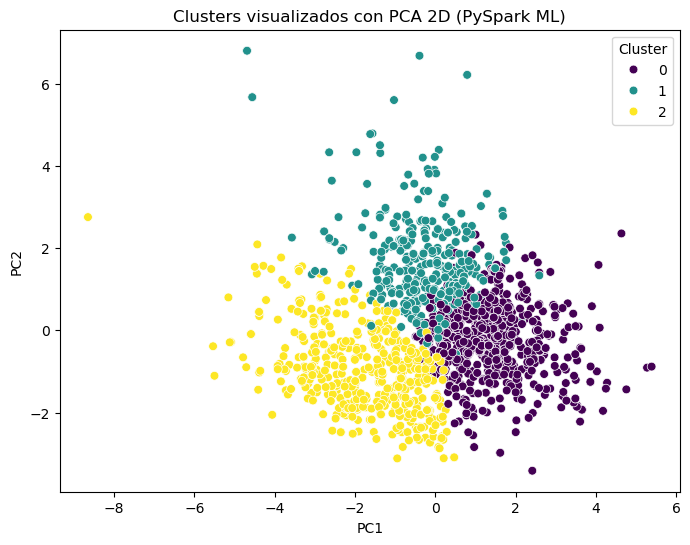

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pyspark.ml.feature import PCA

# 1. Aplicar PCA (2 componentes) sobre las features
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")

# Ajustamos PCA usando el DataFrame con clusters
pca_model = pca.fit(kmeans_predictions)

# Transformamos para obtener las coordenadas en 2D
df_pca = pca_model.transform(kmeans_predictions)

# 2. Pasar a Pandas para graficar
pdf = df_pca.select("pcaFeatures", "cluster").toPandas()

# Extraer PC1 y PC2 desde el vector pcaFeatures
pdf["PC1"] = pdf["pcaFeatures"].apply(lambda v: float(v[0]))
pdf["PC2"] = pdf["pcaFeatures"].apply(lambda v: float(v[1]))

# 3. Dibujar scatter 2D coloreado por cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pdf,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="viridis",
    s=40
)

plt.title("Clusters visualizados con PCA 2D (PySpark ML)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


## Resumen del analisis

Con este cuaderno se demostró el uso de Spark para entrenamiento y evaluacion de modelos no supervisados, siguiendo los siguientes pasos:

1. **Carga de Datos**: Se cargó el conjunto de datos Wine Quality y se convirtió a DataFrame de Spark
2. **Preprocesamiento**: Se normalizaron las características usando StandardScaler para mejorar el rendimiento del clustering
3. **Entrenamiento de Modelos**: Se entrenaron modelos de K-Means y Bisecting K-Means con 3 clusters
4. **Evaluación**: Se compararon los modelos usando Silhouette Score y suma de errores al cuadrado
5. **Análisis**: Se analizó la relación entre clusters descubiertos y la calidad real del vino

### Principales Conclusiones:

- El **Dataset** contiene 1,599 muestras de vino tinto con 11 características químicas, el cual se destribuye entre los workers durante el manejo de datos.
- Los **modelos de clustering** identifican grupos naturales en los datos sin etiquetas previas, lo que permite descubrir patrones ocultos.
- **K-Means** es un algoritmo iterativo que asigna puntos al centroide más cercano y actualiza centroides, es eficiente pero puede converger a óptimos locales.
- **Bisecting K-Means** usa una estrategia divisiva jerárquica que parte de un cluster y lo divide recursivamente, generalmente más estable que K-Means estándar.
- La **normalización** de características es crucial para clustering ya que características con diferentes escalas pueden dominar el cálculo de distancias.
- El **Silhouette Score** mide qué tan similares son los objetos dentro de su cluster comparado con otros clusters (rango: -1 a 1, mejor cerca de 1).
- Los clusters descubiertos muestran correlación con la calidad real del vino, lo que valida que las características químicas agrupan vinos de calidad similar.